# Model Evaluation

In this notebook, I will test different models to classify the tweets.

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from timeit import default_timer as timer

In [164]:
import gc

# remove unnecessary variables
def clean_up(vars_):
    for var in vars_:
        del var 
    print(gc.collect())

In [165]:
X_train = pd.read_pickle('PKL/X_train_fin.pkl')
X_val = pd.read_pickle('PKL/X_val_fin.pkl')
y_train = pd.read_csv('DATA/y_train.csv', index_col=0)
y_val = pd.read_csv('DATA/y_val.csv', index_col=0)

In [166]:
X_train_tweet = X_train['tweet_df']
X_val_tweet = X_val['tweet_df']

In [167]:
X_train = X_train.drop('tweet_df', axis = 1)
X_val = X_val.drop('tweet_df', axis = 1)

In [168]:
y_train = y_train['sentiment']
y_val = y_val['sentiment']

In [169]:
original_features = X_train.columns

## Evaluation Metrics
It is a multi-class classification problem with class imbalance. Since the goal of the project is to build a model that accurately classifies positive, negative or neutral sentiment than detecting any specific class, so I'll use accuracy as a measure. I'll also look at cohen's kappa score. 

In [170]:
from sklearn.metrics import accuracy_score, cohen_kappa_score
scoreboard = {}
def scoring(title, y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    ck = cohen_kappa_score(y_test, y_pred)
    scoreboard[title] = (round(acc, 4), round(ck, 4)) 
    return scoreboard

## Class Imbalance
Currently our dataset has a class imbalance issue. I'll first try to resolve this by oversampling using SMOTE.

In [171]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(n_jobs = -1, random_state=22)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [172]:
X_train.shape

(7905, 2091)

In [173]:
y_train.value_counts()

No emotion toward brand or product    2635
Negative emotion                      2635
Positive emotion                      2635
Name: sentiment, dtype: int64

## Standardization

In [174]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

## Feature Selection
Since we are a bit top heavy, let's remove some of them.

In [181]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

etc = ExtraTreesClassifier(n_estimators = 100, n_jobs = 3, random_state = 23)
etc = etc.fit(X_train, y_train)
model = SelectFromModel(etc, prefit = True, threshold = 1e-4)

In [182]:
X_train = model.transform(X_train)
new_feats = original_features[model.get_support()]

In [183]:
X_val = model.transform(X_val)

## Baseline Model 
---
First I'll run a baseline model using dummy classifier.

In [184]:
from sklearn.dummy import DummyClassifier

In [185]:
start = timer()

dummy_classifier = DummyClassifier(strategy='stratified')
dummy_classifier.fit(X_train, y_train)
y_pred = dummy_classifier.predict(X_val)

end = timer()
print(scoring('dummy', y_val, y_pred))

print('Total Time Elapsed:', end - start)

{'dummy': (0.3342, 0.0148)}
Total Time Elapsed: 0.0164305000071181


## Random Forest
---


In [186]:
from sklearn.ensemble import RandomForestClassifier
start = timer()

rfc = RandomForestClassifier(n_jobs = -2, random_state=18)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_val)

end = timer()
print(scoring('simple random forest', y_val, y_pred))

print('Total Time Elapsed:', end - start)

{'dummy': (0.3342, 0.0148), 'simple random forest': (0.6328, 0.2441)}
Total Time Elapsed: 3.715095976003795


## SVM
---

In [187]:
from sklearn.svm import SVC

start = timer()

svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_val)

end = timer()
print(scoring('simple svm', y_val, y_pred))

print('Total Time Elapsed:', end - start)

{'dummy': (0.3342, 0.0148), 'simple random forest': (0.6328, 0.2441), 'simple svm': (0.6266, 0.2333)}
Total Time Elapsed: 145.24808685800235


## XGBoost
---

In [188]:
import xgboost as xgb

In [190]:
xgbc = xgb.XGBClassifier(eta = 0.05, max_depth = 10, objective = 'multi:softmax', n_jobs = 3)
xgbc.fit(X_train, y_train)

XGBClassifier(eta=0.05, max_depth=10, n_jobs=3, objective='multi:softprob')

In [220]:
y_pred = xgbc.predict(X_val)
print(scoring('simple xgboost', y_val, y_pred))

{'dummy': (0.3342, 0.0148), 'simple random forest': (0.6328, 0.2441), 'simple svm': (0.6337, 0.2843), 'simple xgboost': (0.6337, 0.2843)}


In [222]:
scoreboard

{'dummy': (0.3342, 0.0148),
 'simple random forest': (0.6328, 0.2441),
 'simple svm': (0.6266, 0.2333),
 'simple xgboost': (0.6337, 0.2843)}

## LSTM
---
Let's try deep learning approach instead.

In [238]:
from tensorflow.keras.layers import LSTM, Input, Embedding, GlobalMaxPool1D, Dropout, Dense, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [224]:
labels_set = pd.get_dummies(y_train)
labels = labels_set.values

In [228]:
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(X_train_tweet)
seq_X_train = tokenizer.texts_to_sequences(X_train_tweet)
seq_X_train = pad_sequences(seq_X_train)

In [234]:
seq_X_train.shape

(4488, 31)

In [263]:
model = Sequential()
model.add(Embedding(5000, 64, input_length = 31))
model.add(LSTM(64, dropout = 0.5, recurrent_dropout = 0.5, return_sequences = True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation = 'softmax'))

model.compile(optimizer = 'adam', 
             loss = 'categorical_crossentropy', 
             metrics = ['accuracy'])

In [264]:
cb = EarlyStopping(monitor = 'val_loss', verbose = 1, patience = 5, restore_best_weights = True)

start = timer()
history = model.fit(seq_X_train, labels,
                   epochs = 100, 
                   validation_split = 0.3, 
                   verbose = 2, 
                   callbacks = [cb], 
                   shuffle=True)

end = timer()
print('Total Time Elapsed:', end-start)

Epoch 1/100
99/99 - 7s - loss: 0.8886 - accuracy: 0.5852 - val_loss: 0.8968 - val_accuracy: 0.5568
Epoch 2/100
99/99 - 4s - loss: 0.8560 - accuracy: 0.5992 - val_loss: 0.8924 - val_accuracy: 0.5568
Epoch 3/100
99/99 - 4s - loss: 0.8256 - accuracy: 0.6001 - val_loss: 0.8575 - val_accuracy: 0.5568
Epoch 4/100
99/99 - 4s - loss: 0.7511 - accuracy: 0.6266 - val_loss: 0.8747 - val_accuracy: 0.6088
Epoch 5/100
99/99 - 4s - loss: 0.6626 - accuracy: 0.6982 - val_loss: 0.8965 - val_accuracy: 0.6214
Epoch 6/100
99/99 - 4s - loss: 0.5700 - accuracy: 0.7650 - val_loss: 1.0005 - val_accuracy: 0.6192
Epoch 7/100
99/99 - 4s - loss: 0.4921 - accuracy: 0.8042 - val_loss: 1.0612 - val_accuracy: 0.6244
Epoch 8/100
Restoring model weights from the end of the best epoch.
99/99 - 4s - loss: 0.4411 - accuracy: 0.8262 - val_loss: 1.3067 - val_accuracy: 0.6125
Epoch 00008: early stopping
Total Time Elapsed: 33.24105913200765


In [87]:
#model.save('MODEL/LSTM_v1.h5')

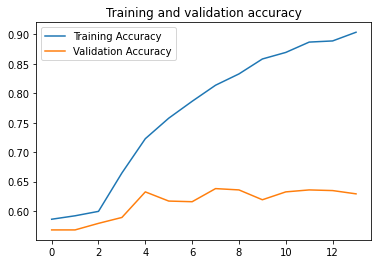

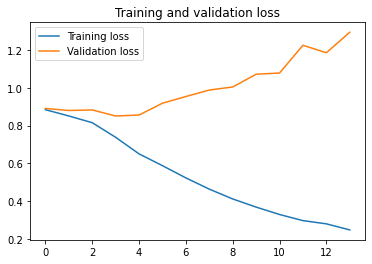

In [258]:
# plot performance
def plot_performance(hist):
    hist_ = hist.history
    epochs = hist.epoch

    plt.plot(epochs, hist_['accuracy'], label='Training Accuracy')
    plt.plot(epochs, hist_['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, hist_['loss'], label='Training loss')
    plt.plot(epochs, hist_['val_loss'], label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()
    
plot_performance(model.history)

In [265]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

In [269]:
model = Sequential()
model.add(Embedding(5000, 64, input_length=31))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='sigmoid'))


model.compile(optimizer = 'adam', 
             loss = 'categorical_crossentropy', 
             metrics = ['accuracy'])

In [271]:
cb = EarlyStopping(monitor = 'val_loss', verbose = 1, patience = 5, restore_best_weights = True)

start = timer()
history = model.fit(seq_X_train, labels,
                   epochs = 100, 
                   validation_split = 0.3, 
                   verbose = 2, 
                   callbacks = [cb], 
                   shuffle=True)

end = timer()
print('Total Time Elapsed:', end-start)

Epoch 1/100
99/99 - 1s - loss: 0.8914 - accuracy: 0.5922 - val_loss: 0.8914 - val_accuracy: 0.5568
Epoch 2/100
99/99 - 0s - loss: 0.7970 - accuracy: 0.6030 - val_loss: 0.8551 - val_accuracy: 0.5598
Epoch 3/100
99/99 - 0s - loss: 0.6225 - accuracy: 0.7186 - val_loss: 0.9019 - val_accuracy: 0.6177
Epoch 4/100
99/99 - 0s - loss: 0.3745 - accuracy: 0.8532 - val_loss: 0.9811 - val_accuracy: 0.6169
Epoch 5/100
99/99 - 0s - loss: 0.2362 - accuracy: 0.8908 - val_loss: 1.0870 - val_accuracy: 0.6043
Epoch 6/100
99/99 - 0s - loss: 0.1754 - accuracy: 0.9089 - val_loss: 1.1844 - val_accuracy: 0.6110
Epoch 7/100
Restoring model weights from the end of the best epoch.
99/99 - 0s - loss: 0.1366 - accuracy: 0.9147 - val_loss: 1.3034 - val_accuracy: 0.6088
Epoch 00007: early stopping
Total Time Elapsed: 4.129451858010725


In [ ]:
# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
            weight_matrix[i] = vector
    return weight_matrix

In [ ]:
# load embedding from file
raw_embedding = load_embedding('glove.6B.100d.txt')
# get vectors in the right order
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
# create the embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_vectors], 
                            input_length=max_length, trainable=False)

In [ ]:
# define model
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
print(model.summary())